In [414]:
!pip freeze > requirements.txt

In [31]:
#data
import numpy as np
import pandas as pd
import sqlite3

#ml pnl
import gensim
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from wordcloud import WordCloud

#analisys
from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn.metrics.pairwise import cosine_similarity

#plot
import matplotlib.pyplot as plt
import seaborn as sns

#aux
import os
import pickle
from IPython.display import clear_output


np.set_printoptions(suppress=True, formatter={'float_kind':'{:16.3f}'.format}, linewidth=130)
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## exploração de dados
- hipótese a verificar:
    - verificar se a diferença entre os parâmetros dos itens se correlacionam com as medidas de similaridade dos itens; será que itens similares os semanticamente similares possuem pouca diferença em relação aos parâmetros?
    - espera-se que quanto maior a similaridade dos itens menor a diferença entre os parâmetros;

- análise interessante a obter:
    - nuvem de palavras dos textos de todos os itens de cada ano;

In [303]:
# load the dataframe object from the pickle file
with open(os.path.join('data', 'df_itens_geral_validos.pkl'), 'rb') as f:
    dataset = pickle.load(f)

In [304]:
dataset.columns

Index(['co_posicao', 'sg_area', 'co_item', 'tx_gabarito', 'co_habilidade',
       'in_item_aban', 'tx_motivo_aban', 'nu_param_a', 'nu_param_b',
       'nu_param_c', 'tx_cor', 'co_prova', 'id', 'ano', 'cor',
       'meio_aplicacao', 'num_questao', 'area', 'texto_questao', 'texto_base',
       'alternativa_a', 'alternativa_b', 'alternativa_c', 'alternativa_d',
       'alternativa_e', 'tp_lingua', 'in_item_adaptado', 'tp_versao_digital',
       'texto_questao_tratado', 'wes', 'tf_idf', 'wes_own',
       'classes_param_a_1', 'classes_param_b_1', 'classes_param_c_1'],
      dtype='object')

In [305]:
#selecionar as colunas de interesse
data = dataset.loc[:, ['id', 'ano', 'nu_param_a', 'nu_param_b', 'nu_param_c', 'tf_idf', 'wes', 'wes_own', 'sg_area', 'classes_param_a_1', 'classes_param_b_1', 'classes_param_c_1']]

In [306]:
data

id        ano  nu_param_a  nu_param_b  nu_param_c  \
0       1_CH_AZUL 2010.00000     2.23777     1.04258     0.29804   
1       2_CH_AZUL 2010.00000     1.35599     1.23358     0.23895   
2       3_CH_AZUL 2010.00000     1.58426     1.26006     0.19016   
3       4_CH_AZUL 2010.00000     1.87124    -0.40493     0.17401   
4       5_CH_AZUL 2010.00000     0.40830     1.46209     0.02447   
...           ...        ...         ...         ...         ...   
1917  115_CN_AZUL 2021.00000     2.72669     1.99105     0.20284   
1918  129_CN_AZUL 2021.00000     3.29305     1.87858     0.17777   
1919   92_CN_AZUL 2021.00000     3.01758     1.65693     0.15293   
1920  104_CN_AZUL 2021.00000     3.24877     1.21839     0.09433   
1921  111_CN_AZUL 2021.00000     1.41618     0.30941     0.07884   

                                                 tf_idf  \
0     [0.15448001662671257, 0.19314334362072388, 0.1...   
1     [0.14463912531808382, 0.1882090195082598, 0.11...   
2     [0.08937166525923214, 0.12822456358498585, 0.1...   
3     [0.07309805460729854, 0.07309805460729854, 0.0...   
4     [0.238915125308662, 0.2103826054875806, 0.2674...   
...                                                 ...   
1917  [0.05619102715705249, 0.06916741900157027, 0.0...   
1918  [0.1528893527738725, 0.2600060925862451, 0.209...   
1919  [0.11929146186934009, 0.19125392140927147, 0.5...   
1920  [0.17188810429433815, 0.14762382523360137, 0.1...   
1921  [0.09955778733682868, 0.07829506004930323, 0.0...   

                                                    wes  \
0     [[0.0087, -0.015, 0.073, 0.0244, -0.0139, -0.0...   
1     [[-0.0457, -0.009, 0.0753, -0.0198, -0.0479, -...   
2     [[-0.0246, -0.0379, 0.1021, 0.0378, -0.0864, -...   
3     [[-0.0016, -0.0689, 0.0547, -0.0424, 0.0693, -...   
4     [[-0.0128, -0.0053, 0.029, -0.052, -0.0304, -0...   
...                                                 ...   
1917  [[-0.0141, 0.0021, 0.0354, -0.0111, -0.0444, -...   
1918  [[0.0061, -0.0594, -0.0064, 0.0171, 0.0129, -0...   
1919  [[0.1122, -0.1142, 0.174, -0.0254, 0.0135, -0....   
1920  [[0.0164, -0.0423, 0.0183, 0.0021, -0.0077, -0...   
1921  [[-0.0287, 0.0194, 0.0718, 0.0233, 0.0035, -0....   

                                                wes_own sg_area  \
0     [[-0.2735036, -0.19421376, 0.26711008, 0.26224...      CH   
1     [[0.33006182, 0.08265074, 0.0863686, 0.1423417...      CH   
2     [[0.2161539, 0.16423477, -0.022779496, 0.32457...      CH   
3     [[-0.06490169, 0.25573078, 0.082524896, 0.1681...      CH   
4     [[-0.123734914, 0.036533087, 0.20261528, 0.195...      CH   
...                                                 ...     ...   
1917  [[-0.12732956, 0.21505068, 0.08557004, 0.11845...      CN   
1918  [[-0.028699033, 0.074642524, 0.024855392, 0.09...      CN   
1919  [[-0.05222235, 0.12967859, 0.03100298, 0.15160...      CN   
1920  [[-0.1365928, 0.19706728, 0.044643518, 0.17139...      CN   
1921  [[-0.064215235, 0.30952683, 0.068533145, 0.427...      CN   

     classes_param_a_1 classes_param_b_1   classes_param_c_1  
0     >2.092 e <=2.735  >0.652 e <=1.224              >0.203  
1              <=1.581  >1.224 e <=1.837              >0.203  
2     >1.581 e <=2.092  >1.224 e <=1.837      >165 e <=0.203  
3     >1.581 e <=2.092           <=0.652      >165 e <=0.203  
4              <=1.581  >1.224 e <=1.837           <=0.12487  
...                ...               ...                 ...  
1917  >2.092 e <=2.735            >1.837      >165 e <=0.203  
1918            >2.735            >1.837      >165 e <=0.203  
1919            >2.735  >1.224 e <=1.837  >0.12487 e <=0.165  
1920            >2.735  >0.652 e <=1.224           <=0.12487  
1921           <=1.581           <=0.652           <=0.12487  

[1922 rows x 12 columns]

A **similaridade do cosseno** é uma medida de similaridade entre dois vetores em um espaço vetorial. Ela mede o ângulo entre dois vetores e é calculada como o cosseno desse ângulo. Se o ângulo entre dois vetores é zero, eles são totalmente similares e a similaridade do cosseno é 1.0. Se o ângulo é de 90 graus, os vetores são completamente dissimilar e a similaridade do cosseno é 0.0. A similaridade do cosseno é uma medida comum para determinar a similaridade entre vetores de word embeddings ou TF-IDF.

A **medida de similaridade do coseno entre dois vetores tf-idf** pode fornecer informações sobre a similaridade entre os termos (palavras) que aparecem nos vetores e, consequentemente, sobre os tópicos (ou aspectos) relacionados a esses termos. Um valor alto de similaridade do coseno indica que os dois vetores são semelhantes em termos de seus termos (palavras) e, portanto, podem estar relacionados a tópicos semelhantes. Por outro lado, um valor baixo de similaridade do coseno indica que os dois vetores têm termos (palavras) diferentes e, portanto, podem estar relacionados a tópicos diferentes. Portanto, a medida de similaridade do coseno entre dois vetores tf-idf pode ser útil para inferir aspectos em comum entre documentos ou textos.

A **medida de similaridade do cosseno entre dois vetores de word embeddings** pode inferir sobre a similaridade semântica entre as palavras contidas nesses vetores. Quanto mais próximos os vetores estiverem no espaço de representação, mais semelhantes serão os significados das palavras correspondentes. Isso pode ser útil em tarefas como análise de sentimento, onde palavras com significados semelhantes geralmente têm uma polaridade semelhante. Também pode ser útil em tarefas de agrupamento de documentos, onde documentos com palavras semanticamente similares podem ser agrupados juntos.

### matriz de similaridade item-item e diferenças parâmetro-parâmetro

In [328]:
#obter as similaridades item-item e a diferença entre os parametros
param_a = data['nu_param_a'].values
param_b = data['nu_param_b'].values
param_c = data['nu_param_c'].values
tf_idf = data['tf_idf'].values
wes = data['wes']
wes_own = data['wes_own']
max_size = data['tf_idf'].apply(len).max()
similaridades = []
print(max_size)
for i, v1 in enumerate(tf_idf):
    for j, v2 in enumerate(tf_idf):
        print(i, j)
        v1_ = np.array(v1)
        v2_ = np.array(v2)
        we1 = wes[i]
        we1 = np.array(we1).flatten()
        we2 = wes[j]
        we2 = np.array(we2).flatten()
        we_own1 = wes_own[i]
        we_own1 = np.array(we_own1).flatten()
        we_own2 = wes_own[j]
        we_own2 = np.array(we_own2).flatten()
        #print(we1.shape[0], we2.shape[0])
        if (len(v1_) > len(v2_)):
            print('v1 > v2')
            v2_ = pad_sequences([v2_], padding='post', maxlen=len(v1_), dtype='float')
        elif (len(v2_) > len(v1_)):
            print('v2 > v1')
            v1_ = pad_sequences([v1_], padding='post', maxlen=len(v2_), dtype='float')
            
        if (we1.shape[0] > we2.shape[0]):
            we2 = pad_sequences([we2], padding='post', maxlen=len(we1), dtype='float')
            we2 = we2.flatten()
        elif (we2.shape[0] > we1.shape[0]):
            we1 = pad_sequences([we1], padding='post', maxlen=len(we2), dtype='float')
            we1 = we1.flatten()
            
        if (we_own1.shape[0] > we_own2.shape[0]):
            we_own2 = pad_sequences([we_own2], padding='post', maxlen=len(we_own1), dtype='float')
            we_own2 = we_own2.flatten()
        elif (we_own2.shape[0] > we_own1.shape[0]):
            we_own1 = pad_sequences([we_own1], padding='post', maxlen=len(we_own2), dtype='float')
            we_own1 = we_own1.flatten()
        
        if (param_a[i] >= param_a[j]):
            dif_param_a = param_a[i] - param_a[j]
        elif (param_a[i] <= param_a[j]):
            dif_param_a = param_a[j] - param_a[i]
            
        if (param_b[i] >= param_b[j]):
            dif_param_b = param_b[i] - param_b[j]
        elif (param_b[i] <= param_b[j]):
            dif_param_b = param_b[j] - param_b[i]
            
        if (param_c[i] >= param_c[j]):
            dif_param_c = param_c[i] - param_c[j]
        elif (param_c[i] <= param_c[j]):
            dif_param_c = param_c[j] - param_c[i]
        
        sim_q_tf_idf = cosine_similarity(np.array(v1_).reshape(1, -1), np.array(v2_).reshape(1, -1))
        sim_q_we = cosine_similarity(np.array(we1).reshape(1, -1), np.array(we2).reshape(1, -1))
        sim_q_we_own = cosine_similarity(np.array(we_own1).reshape(1, -1), np.array(we_own2).reshape(1, -1))
        similaridades.append([sim_q_we_own[0][0], sim_q_we[0][0], sim_q_tf_idf[0][0], dif_param_a, dif_param_b, dif_param_c, i, j, data.at[i, 'classes_param_a_1'], data.at[j, 'classes_param_a_1'], data.at[i, 'classes_param_b_1'], data.at[j, 'classes_param_b_1'], data.at[i, 'classes_param_c_1'], data.at[j, 'classes_param_c_1'], data.at[i, 'sg_area'], data.at[j, 'sg_area'], data.at[i, 'id'], data.at[j, 'id'], data.at[i, 'ano'], data.at[j, 'ano']])
        print([sim_q_we_own[0][0], sim_q_we[0][0], sim_q_tf_idf[0][0], dif_param_a, dif_param_b, dif_param_c, i, j, data.at[i, 'classes_param_a_1'], data.at[j, 'classes_param_a_1'], data.at[i, 'classes_param_b_1'], data.at[j, 'classes_param_b_1'], data.at[i, 'classes_param_c_1'], data.at[j, 'classes_param_c_1'], data.at[i, 'sg_area'], data.at[j, 'sg_area'], data.at[i, 'id'], data.at[j, 'id'], data.at[i, 'ano'], data.at[j, 'ano']])
        clear_output(wait=True)

1921 1921
[1.0000005, 0.99999946, 1.0000000000000002, 0.0, 0.0, 0.0, 1921, 1921, '<=1.581', '<=1.581', '<=0.652', '<=0.652', '<=0.12487', '<=0.12487', 'CN', 'CN', '111_CN_AZUL', '111_CN_AZUL', 2021.0, 2021.0]


In [329]:
df_similaridades = pd.DataFrame(similaridades, columns = ['sim_q_we_own', 'sim_q_we', 'sim_q_tf_idf', 'dif_param_a', 'dif_param_b','dif_param_c', 'item1', 'item2', 'item1_classes_param_a_1', 'item2_classes_param_a_1', 'item1_classes_param_b_1', 'item2_classes_param_b_1', 'item1_classes_param_c_1', 'item2_classes_param_c_1', 'item1_area', 'item2_area', 'item1_id', 'item2_id', 'item1_ano', 'item2_ano'])

In [330]:
df_similaridades.head()

sim_q_we_own  sim_q_we  sim_q_tf_idf  dif_param_a  dif_param_b  dif_para_c  \
0       1.00000   1.00000       1.00000      0.00000      0.00000     0.00000   
1       0.26376   0.03533       0.62742      0.88178      0.19100     0.05909   
2       0.21963   0.03539       0.51536      0.65351      0.21748     0.10788   
3       0.21010   0.04850       0.42144      0.36653      1.44751     0.12403   
4       0.41965   0.03769       0.84327      1.82947      0.41951     0.27357   

   item1  item2 item1_classes_param_a_1 item2_classes_param_a_1  \
0      0      0        >2.092 e <=2.735        >2.092 e <=2.735   
1      0      1        >2.092 e <=2.735                 <=1.581   
2      0      2        >2.092 e <=2.735        >1.581 e <=2.092   
3      0      3        >2.092 e <=2.735        >1.581 e <=2.092   
4      0      4        >2.092 e <=2.735                 <=1.581   

  item1_classes_param_b_1 item2_classes_param_b_1 item1_classes_param_c_1  \
0        >0.652 e <=1.224        >0.652 e <=1.224                  >0.203   
1        >0.652 e <=1.224        >1.224 e <=1.837                  >0.203   
2        >0.652 e <=1.224        >1.224 e <=1.837                  >0.203   
3        >0.652 e <=1.224                 <=0.652                  >0.203   
4        >0.652 e <=1.224        >1.224 e <=1.837                  >0.203   

  item2_classes_param_c_1 item1_area item2_area   item1_id   item2_id  \
0                  >0.203         CH         CH  1_CH_AZUL  1_CH_AZUL   
1                  >0.203         CH         CH  1_CH_AZUL  2_CH_AZUL   
2          >165 e <=0.203         CH         CH  1_CH_AZUL  3_CH_AZUL   
3          >165 e <=0.203         CH         CH  1_CH_AZUL  4_CH_AZUL   
4               <=0.12487         CH         CH  1_CH_AZUL  5_CH_AZUL   

   item1_ano  item2_ano  
0 2010.00000 2010.00000  
1 2010.00000 2010.00000  
2 2010.00000 2010.00000  
3 2010.00000 2010.00000  
4 2010.00000 2010.00000

In [331]:
file = os.path.join('data', 'df_similaridades.csv')
df_similaridades.to_csv(file, index = False, sep = ';')

In [332]:
file = os.path.join('data', 'df_similaridades.csv')
df_similaridades = pd.read_csv(file, sep = ';')

In [334]:
df_similaridades.shape

(3694084, 20)

In [335]:
df_similaridades['e_maior'] = df_similaridades['item1'] >= df_similaridades['item2']

In [336]:
df_similaridades[df_similaridades.e_maior == False].head()

sim_q_we_own  sim_q_we  sim_q_tf_idf  dif_param_a  dif_param_b  dif_para_c  \
1       0.26376   0.03533       0.62742      0.88178      0.19100     0.05909   
2       0.21963   0.03539       0.51536      0.65351      0.21748     0.10788   
3       0.21010   0.04850       0.42144      0.36653      1.44751     0.12403   
4       0.41965   0.03769       0.84327      1.82947      0.41951     0.27357   
5       0.24793   0.05382       0.62907      1.04007      0.23799     0.15081   

   item1  item2 item1_classes_param_a_1 item2_classes_param_a_1  ...  \
1      0      1        >2.092 e <=2.735                 <=1.581  ...   
2      0      2        >2.092 e <=2.735        >1.581 e <=2.092  ...   
3      0      3        >2.092 e <=2.735        >1.581 e <=2.092  ...   
4      0      4        >2.092 e <=2.735                 <=1.581  ...   
5      0      5        >2.092 e <=2.735                 <=1.581  ...   

  item2_classes_param_b_1 item1_classes_param_c_1 item2_classes_param_c_1  \
1        >1.224 e <=1.837                  >0.203                  >0.203   
2        >1.224 e <=1.837                  >0.203          >165 e <=0.203   
3                 <=0.652                  >0.203          >165 e <=0.203   
4        >1.224 e <=1.837                  >0.203               <=0.12487   
5        >1.224 e <=1.837                  >0.203      >0.12487 e <=0.165   

  item1_area item2_area   item1_id   item2_id  item1_ano  item2_ano  e_maior  
1         CH         CH  1_CH_AZUL  2_CH_AZUL 2010.00000 2010.00000    False  
2         CH         CH  1_CH_AZUL  3_CH_AZUL 2010.00000 2010.00000    False  
3         CH         CH  1_CH_AZUL  4_CH_AZUL 2010.00000 2010.00000    False  
4         CH         CH  1_CH_AZUL  5_CH_AZUL 2010.00000 2010.00000    False  
5         CH         CH  1_CH_AZUL  6_CH_AZUL 2010.00000 2010.00000    False  

[5 rows x 21 columns]

In [349]:
df_similaridades[(df_similaridades.e_maior == False)].sort_values(by = 'sim_q_we_own', ascending=False).loc[:, ['sim_q_we_own', 'sim_q_we', 'sim_q_tf_idf', 'item1', 'item2', 'item1_classes_param_a_1', 'item2_classes_param_a_1', 'item1_classes_param_b_1', 'item2_classes_param_b_1', 'item1_classes_param_c_1', 'item2_classes_param_c_1', 'item1_ano', 'item2_ano']].describe()

sim_q_we_own      sim_q_we  sim_q_tf_idf         item1         item2  \
count 1846081.00000 1846081.00000 1846081.00000 1846081.00000 1846081.00000   
mean        0.30629       0.06109       0.59611     640.00000    1281.00000   
std         0.07020       0.03522       0.13966     452.90188     452.90188   
min         0.02849      -0.01590       0.08519       0.00000       1.00000   
25%         0.25798       0.03751       0.49847     257.00000     961.00000   
50%         0.30823       0.05381       0.60267     562.00000    1359.00000   
75%         0.35513       0.07572       0.70024     960.00000    1664.00000   
max         1.00000       1.00000       0.99128    1920.00000    1921.00000   

          item1_ano     item2_ano  
count 1846081.00000 1846081.00000  
mean     2014.59599    2018.59444  
std         3.37929       2.48802  
min      2010.00000    2010.00000  
25%      2012.00000    2017.00000  
50%      2014.00000    2020.00000  
75%      2017.00000    2020.00000  
max      2021.00000    2021.00000

In [350]:
#(df_similaridades.item1_area == 'CN') & (df_similaridades.item2_area == 'CH') & (df_similaridades.sim_q_tf_idf < 0.99)
df_similaridades[(df_similaridades.e_maior == False)].sort_values(by = 'sim_q_we', ascending=False).loc[:, ['sim_q_we_own', 'sim_q_we', 'sim_q_tf_idf', 'item1', 'item2', 'item1_classes_param_a_1', 'item2_classes_param_a_1', 'item1_classes_param_b_1', 'item2_classes_param_b_1', 'item1_classes_param_c_1', 'item2_classes_param_c_1', 'item1_ano', 'item2_ano']].head(60)

sim_q_we_own  sim_q_we  sim_q_tf_idf  item1  item2  \
3442177       1.00000   1.00000       0.98806   1790   1797   
1542354       1.00000   1.00000       0.99021    802    910   
3376831       1.00000   1.00000       0.98594   1756   1799   
3401816       1.00000   1.00000       0.99128   1769   1798   
205762        0.88141   0.81897       0.70539    107    108   
554082        0.67797   0.76286       0.73762    288    546   
2154333       0.76942   0.69376       0.95147   1120   1693   
2063438       0.73165   0.63605       0.89133   1073   1132   
737199        0.65208   0.62012       0.88557    383   1073   
2875078       0.56831   0.58017       0.70063   1495   1688   
2896281       0.49094   0.57120       0.89469   1506   1749   
2327115       0.56017   0.57083       0.69277   1210   1495   
245690        0.51993   0.57068       0.91496    127   1596   
118913        0.62209   0.56733       0.63855     61   1671   
2988366       0.45676   0.56446       0.85695   1554   1578   
226412        0.58323   0.56261       0.67912    117   1538   
737258        0.67346   0.56023       0.93569    383   1132   
2403990       0.56849   0.55618       0.90064   1250   1490   
2327308       0.53642   0.55519       0.78303   1210   1688   
2034608       0.59508   0.54153       0.80019   1058   1132   
1581105       0.61825   0.54076       0.66659    822   1221   
595252        0.61162   0.53754       0.91216    309   1354   
1170036       0.67837   0.53295       0.73004    608   1460   
2015801       0.54618   0.52987       0.86271   1048   1545   
1698049       0.60667   0.52267       0.67280    883    923   
291064        0.58010   0.51847       0.55565    151    842   
2642208       0.63422   0.51628       0.79666   1374   1380   
1006201       0.64044   0.51373       0.75741    523    995   
1271490       0.57182   0.50793       0.88064    661   1048   
1090498       0.69130   0.50641       0.88262    567    724   
1271987       0.57987   0.50007       0.91122    661   1545   
1325077       0.57881   0.49744       0.73096    689    819   
495623        0.57339   0.49585       0.87091    257   1669   
2161511       0.56833   0.49304       0.86878   1124   1183   
422641        0.70784   0.49184       0.78992    219   1723   
2292602       0.44838   0.49109       0.90529   1192   1578   
1544808       0.52207   0.48173       0.88762    803   1442   
1006338       0.73449   0.47984       0.93005    523   1132   
1514109       0.53293   0.47958       0.66724    787   1495   
1556330       0.51953   0.47907       0.79224    809   1432   
2651898       0.62081   0.47748       0.80293   1379   1460   
1169952       0.60647   0.47671       0.83379    608   1376   
284905        0.56615   0.47629       0.67597    148    449   
398375        0.67082   0.47527       0.75213    207    521   
2292578       0.53937   0.47343       0.87737   1192   1554   
931941        0.68027   0.47245       0.95066    484   1693   
1675074       0.39590   0.47214       0.32895    871   1012   
1619891       0.56065   0.47158       0.54431    842   1567   
272434        0.56164   0.47054       0.80478    141   1432   
458608        0.48296   0.47002       0.83123    238   1172   
2217257       0.54165   0.46999       0.86795   1153   1191   
2646051       0.59668   0.46896       0.86737   1376   1379   
957829        0.41045   0.46871       0.55364    498    673   
1109989       0.57722   0.46859       0.77736    577    995   
1514302       0.50717   0.46671       0.76248    787   1688   
1412021       0.53194   0.46520       0.59989    734   1273   
28085         0.53270   0.46415       0.85954     14   1177   
1919386       0.54170   0.46404       0.69473    998   1230   
398906        0.64529   0.46189       0.76572    207   1052   
2521308       0.50106   0.46178       0.78263   1311   1566   

        item1_classes_param_a_1 item2_classes_param_a_1  \
3442177                  >2.735        >1.581 e <=2.092   
1542354                 <=1.581        >1.581 e

In [344]:
print(dataset.loc[523,'texto_questao_tratado'])
print('\n')
print(dataset.loc[995, 'texto_questao_tratado'])

disponível http org br acesso 13 Maio 2013 adaptar preservação sustentabilidade recurso natural expor impedir perfuração poço b coibir uso setor residencial c substituir lei ambiental vigente d reduzir contingente populacional área introduzir gestão participativa município


disponível www org br acesso 15 Maio 2017 adaptar campanha publicitário poder evidenciar problema social cartaz alertar homem agressor sobre consequência ato b conscientizar população sobre necessidade denunciar violência doméstico c instruir mulher sobre fazer caso agressão d despertar criança capacidade reconhecer ato violência doméstico exigir autoridade ação preventivo contra violência doméstico


In [374]:
df_similaridades['classe_param_1_igual'] = df_similaridades['item1_classes_param_a_1'] == df_similaridades['item2_classes_param_a_1']

In [387]:
df_similaridades[(df_similaridades.classe_param_1_igual == True) & (df_similaridades.sim_q_we_own > 0.5) & (df_similaridades.e_maior == False)].sort_values(by = 'sim_q_we_own', ascending = False)

sim_q_we_own  sim_q_we  sim_q_tf_idf  dif_param_a  dif_param_b  \
3401816       1.00000   1.00000       0.99128      0.38612      0.27123   
3376831       1.00000   1.00000       0.98594      0.09541      1.31314   
205762        0.88141   0.81897       0.70539      0.15903      0.60775   
2154333       0.76942   0.69376       0.95147      0.43179      1.88147   
1006338       0.73449   0.47984       0.93005      0.01252      1.77711   
...               ...       ...           ...          ...          ...   
2357698       0.50012   0.08348       0.46567      0.18570      1.00118   
1018425       0.50009   0.24078       0.88687      0.06890      0.17439   
67433         0.50008   0.23431       0.66515      0.24194      0.21555   
238471        0.50007   0.28258       0.58265      0.71469      0.37300   
2010147       0.50004   0.09305       0.70456      0.52889      0.26681   

         dif_para_c  item1  item2 item1_classes_param_a_1  \
3401816     0.06627   1769   1798                  >2.735   
3376831     0.04595   1756   1799        >1.581 e <=2.092   
205762      0.14869    107    108        >2.092 e <=2.735   
2154333     0.06485   1120   1693        >1.581 e <=2.092   
1006338     0.03001    523   1132        >1.581 e <=2.092   
...             ...    ...    ...                     ...   
2357698     0.09645   1226   1326        >1.581 e <=2.092   
1018425     0.14252    529   1687                  >2.735   
67433       0.08160     35    163                 <=1.581   
238471      0.13155    124    143                 <=1.581   
2010147     0.00976   1045   1657        >2.092 e <=2.735   

        item2_classes_param_a_1  ... item1_classes_param_c_1  \
3401816                  >2.735  ...                  >0.203   
3376831        >1.581 e <=2.092  ...          >165 e <=0.203   
205762         >2.092 e <=2.735  ...                  >0.203   
2154333        >1.581 e <=2.092  ...               <=0.12487   
1006338        >1.581 e <=2.092  ...          >165 e <=0.203   
...                         ...  ...                     ...   
2357698        >1.581 e <=2.092  ...               <=0.12487   
1018425                  >2.735  ...               <=0.12487   
67433                   <=1.581  ...               <=0.12487   
238471                  <=1.581  ...                  >0.203   
2010147        >2.092 e <=2.735  ...      >0.12487 e <=0.165   

        item2_classes_param_c_1 item1_area item2_area          item1_id  \
3401816      >0.12487 e <=0.165         CH         LC        70_CH_AZUL   
3376831      >0.12487 e <=0.165         CH         LC        80_CH_AZUL   
205762                <=0.12487         LC         LC       125_LC_AZUL   
2154333      >0.12487 e <=0.165         CH         CH    47_CH_Azul_507   
1006338                  >0.203         CH         CH        38_CH_Azul   
...                         ...        ...        ...               ...   
2357698                  >0.203         CN         MT    95_CN_Rosa_506   
1018425                  >0.203         CH         CH        44_CH_Azul   
67433                 <=0.12487         CH         CN        40_CH_AZUL   
238471                <=0.12487         MT         MT       143_MT_AZUL   
2010147      >0.12487 e <=0.165         LC         CH  9_LC_Amarela_552   

                    item2_id  item1_ano  item2_ano  e_maior  \
3401816            7_LC_AZUL 2021.00000 2021.00000    False   
3376831            8_LC_AZUL 2021.00000 2021.00000    False   
205762           126_LC_AZUL 2010.00000 2010.00000    False   
2154333  77_CH_AMARELA_568_0 2019.00000 2020.00000    False   
1006338       49_CH_Rosa_550 2014.00000 2019.00000    False   
...                      ...        ...        ...      ...   
2357698      148_MT_Rosa_558 2019.00000 2019.00000    False   
1018425  64_CH_AMARELA_688_1 2014.00000 2020.00000    False   
67433             76_CN_Azul 2010.00000 2011.00000    False   
238471           166_MT_AZUL 2010.00000 2010.00000    False   
2010147  55_

In [386]:
df_similaridades[(df_similaridades.classe_param_1_igual == True) & (df_similaridades.sim_q_we > 0.5) & (df_similaridades.e_maior == False)].sort_values(by = 'sim_q_we', ascending = False)

sim_q_we_own  sim_q_we  sim_q_tf_idf  dif_param_a  dif_param_b  \
3376831       1.00000   1.00000       0.98594      0.09541      1.31314   
3401816       1.00000   1.00000       0.99128      0.38612      0.27123   
205762        0.88141   0.81897       0.70539      0.15903      0.60775   
2154333       0.76942   0.69376       0.95147      0.43179      1.88147   
2063438       0.73165   0.63605       0.89133      0.13960      0.77596   
2327115       0.56017   0.57083       0.69277      0.15612      0.75427   
245690        0.51993   0.57068       0.91496      0.26366      0.52626   
2034608       0.59508   0.54153       0.80019      0.34591      0.58726   
2015801       0.54618   0.52987       0.86271      0.14915      1.43487   

         dif_para_c  item1  item2 item1_classes_param_a_1  \
3376831     0.04595   1756   1799        >1.581 e <=2.092   
3401816     0.06627   1769   1798                  >2.735   
205762      0.14869    107    108        >2.092 e <=2.735   
2154333     0.06485   1120   1693        >1.581 e <=2.092   
2063438     0.03479   1073   1132        >1.581 e <=2.092   
2327115     0.03611   1210   1495                  >2.735   
245690      0.01872    127   1596                  >2.735   
2034608     0.15121   1058   1132        >1.581 e <=2.092   
2015801     0.00784   1048   1545        >1.581 e <=2.092   

        item2_classes_param_a_1  ... item1_classes_param_c_1  \
3376831        >1.581 e <=2.092  ...          >165 e <=0.203   
3401816                  >2.735  ...                  >0.203   
205762         >2.092 e <=2.735  ...                  >0.203   
2154333        >1.581 e <=2.092  ...               <=0.12487   
2063438        >1.581 e <=2.092  ...          >165 e <=0.203   
2327115                  >2.735  ...      >0.12487 e <=0.165   
245690                   >2.735  ...                  >0.203   
2034608        >1.581 e <=2.092  ...               <=0.12487   
2015801        >1.581 e <=2.092  ...          >165 e <=0.203   

        item2_classes_param_c_1 item1_area item2_area          item1_id  \
3376831      >0.12487 e <=0.165         CH         LC        80_CH_AZUL   
3401816      >0.12487 e <=0.165         CH         LC        70_CH_AZUL   
205762                <=0.12487         LC         LC       125_LC_AZUL   
2154333      >0.12487 e <=0.165         CH         CH    47_CH_Azul_507   
2063438                  >0.203         LC         CH    13_LC_Rosa_513   
2327115      >0.12487 e <=0.165         CN         CN   93_CN_Cinza_544   
245690           >165 e <=0.203         MT         CN       146_MT_AZUL   
2034608                  >0.203         LC         CH    11_LC_Azul_551   
2015801          >165 e <=0.203         LC         CH  10_LC_Branca_553   

                    item2_id  item1_ano  item2_ano  e_maior  \
3376831            8_LC_AZUL 2021.00000 2021.00000    False   
3401816            7_LC_AZUL 2021.00000 2021.00000    False   
205762           126_LC_AZUL 2010.00000 2010.00000    False   
2154333  77_CH_AMARELA_568_0 2019.00000 2020.00000    False   
2063438       49_CH_Rosa_550 2019.00000 2019.00000    False   
2327115  97_CN_AMARELA_700_1 2019.00000 2020.00000    False   
245690   96_CN_AMARELA_700_1 2010.00000 2020.00000    False   
2034608       49_CH_Rosa_550 2019.00000 2019.00000    False   
2015801  73_CH_AMARELA_568_0 2019.00000 2020.00000    False   

         classe_param_1_igual  
3376831                  True  
3401816                  True  
205762                   True  
2154333                  True  
2063438                  True  
2327115                  True  
245690                   True  
2034608                  True  
2015801                  True  

[9 rows x 22 columns]

In [384]:
df_similaridades[(df_similaridades.classe_param_1_igual == True) & (df_similaridades.sim_q_tf_idf > 0.5) & (df_similaridades.e_maior == False)].sort_values(by = 'sim_q_tf_idf', ascending = False)

sim_q_we_own  sim_q_we  sim_q_tf_idf  dif_param_a  dif_param_b  \
3401816       1.00000   1.00000       0.99128      0.38612      0.27123   
3376831       1.00000   1.00000       0.98594      0.09541      1.31314   
1006899       0.59848   0.12003       0.96073      0.04000      0.92525   
1770118       0.32559   0.02540       0.95638      0.96391      1.68947   
2154333       0.76942   0.69376       0.95147      0.43179      1.88147   
...               ...       ...           ...          ...          ...   
3059768       0.26493   0.04150       0.50000      0.71680      1.77629   
100611        0.31797   0.06571       0.50000      0.58649      0.92459   
140585        0.24797   0.02697       0.50000      0.35876      0.58156   
1419791       0.19501   0.03225       0.50000      0.19890      1.98196   
67087         0.30217   0.04408       0.50000      0.67727      0.74409   

         dif_para_c  item1  item2 item1_classes_param_a_1  \
3401816     0.06627   1769   1798                  >2.735   
3376831     0.04595   1756   1799        >1.581 e <=2.092   
1006899     0.03579    523   1693        >1.581 e <=2.092   
1770118     0.02614    920   1878                  >2.735   
2154333     0.06485   1120   1693        >1.581 e <=2.092   
...             ...    ...    ...                     ...   
3059768     0.18484   1591   1866                 <=1.581   
100611      0.04989     52    667                  >2.735   
140585      0.05979     73    279                  >2.735   
1419791     0.01274    738   1355        >1.581 e <=2.092   
67087       0.18760     34   1739                 <=1.581   

        item2_classes_param_a_1  ... item1_classes_param_c_1  \
3401816                  >2.735  ...                  >0.203   
3376831        >1.581 e <=2.092  ...          >165 e <=0.203   
1006899        >1.581 e <=2.092  ...          >165 e <=0.203   
1770118                  >2.735  ...      >0.12487 e <=0.165   
2154333        >1.581 e <=2.092  ...               <=0.12487   
...                         ...  ...                     ...   
3059768                 <=1.581  ...               <=0.12487   
100611                   >2.735  ...      >0.12487 e <=0.165   
140585                   >2.735  ...          >165 e <=0.203   
1419791        >1.581 e <=2.092  ...          >165 e <=0.203   
67087                   <=1.581  ...               <=0.12487   

        item2_classes_param_c_1 item1_area item2_area              item1_id  \
3401816      >0.12487 e <=0.165         CH         LC            70_CH_AZUL   
3376831      >0.12487 e <=0.165         CH         LC            80_CH_AZUL   
1006899      >0.12487 e <=0.165         CH         CH            38_CH_Azul   
1770118          >165 e <=0.203         CN         CN     16_CN_AMARELA_431   
2154333      >0.12487 e <=0.165         CH         CH        47_CH_Azul_507   
...                         ...        ...        ...                   ...   
3059768          >165 e <=0.203         CN         MT  100_CN_AMARELA_598_0   
100611                   >0.203         CN         CH            58_CN_AZUL   
140585       >0.12487 e <=0.165         CN         CN            82_CN_AZUL   
1419791          >165 e <=0.203         CH         LC      2_CH_AMARELA_436   
67087            >165 e <=0.203         CH         CH            39_CH_AZUL   

                    item2_id  item1_ano  item2_ano  e_maior  \
3401816            7_LC_AZUL 2021.00000 2021.00000    False   
3376831            8_LC_AZUL 2021.00000 2021.00000    False   
1006899  77_CH_AMARELA_568_0 2014.00000 2020.00000    False   
1770118          102_CN_AZUL 2017.00000 2021.00000    False   
2154333  77_CH_AMARELA_568_0 2019.00000 2020.00000    False   
...                      ...        ...        ...      ...   
3059768          170_MT_AZUL 2020.00000 2021.00000    False   
100611             7_CH_Azul 2010.00000 2015.00000    False   
140585          58_CN_Branco 2010.00000 2012.00000    False   
1419791  28_LC_AMARELA_692_

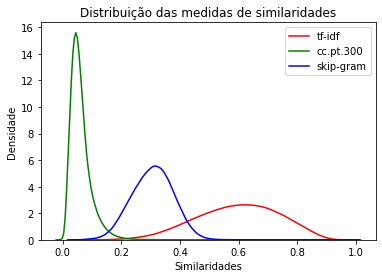

In [399]:
fig, ax = plt.subplots()

sns.kdeplot(data=df_similaridades[(df_similaridades.e_maior == False)], x="sim_q_tf_idf", color='red', label = 'tf-idf', ax = ax)
sns.kdeplot(data=df_similaridades[(df_similaridades.e_maior == False)], x="sim_q_we", color='green', label = 'cc.pt.300', ax = ax)
sns.kdeplot(data=df_similaridades[(df_similaridades.e_maior == False)], x="sim_q_we_own", color='blue', label = 'skip-gram', ax = ax)

# Configurando o gráfico
plt.xlabel("Similaridades")
plt.ylabel("Densidade")
plt.title("Distribuição das medidas de similaridades")
plt.legend()

# Exibindo o gráfico
plt.show()

Ao realizar a **correlação de Spearman**, pode-se verificar a existência de uma relação monotônica entre duas variáveis quantitativas. Isso significa que você pode verificar se uma variação na primeira variável está associada a uma variação semelhante na segunda variável, independentemente da direção da relação.

A correlação de Spearman é útil quando as duas variáveis são ordinais ou quando você deseja verificar a relação entre duas variáveis sem supor nenhuma distribuição específica para as variáveis. A correlação de Spearman é medida por um coeficiente que varia de -1 a 1, onde -1 representa correlação negativa perfeita, 1 representa correlação positiva perfeita e 0 representa ausência de correlação.

A função spearmanr do pacote scipy.stats retorna duas informações principais: o coeficiente de correlação de Spearman e o p-value.

O p-value é uma medida da probabilidade de se obter o coeficiente de correlação de Spearman igual ou mais extrema que o encontrado, dado que as variáveis não são realmente relacionadas. Quanto menor o p-value, mais provável é que as variáveis estejam relacionadas. Valores de p-value abaixo de 0,05 são frequentemente interpretados como indicativos de uma relação significativa.

Em resumo, a função spearmanr retorna uma tupla com dois valores, sendo o primeiro o coeficiente de correlação de Spearman e o segundo o p-value.

A hipótese nula do valor-p retornado pela função spearmanr do scipy é que não há correlação entre as variáveis. Em outras palavras, o valor-p testa se os dados são consistentes com a hipótese de que não há relação entre as variáveis. Quanto menor o valor-p, maior a chance de que a hipótese nula seja rejeitada.

### Correlações entre similaridades

#### cc.pt.300 e treiamento com o conjunto

A hipótese nula foi rejeitada. Há correlação entre as variáveis p-value: 0.0 correlação: 0.5544146458743257


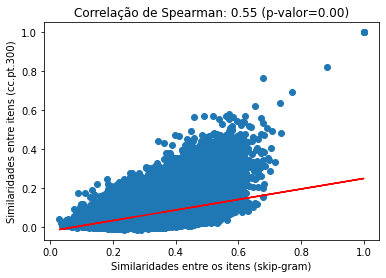

In [397]:
#& (df_similaridades.item1_area == 'LC') & (df_similaridades.item2_area == 'LC') & (df_similaridades.sim_q_we_own < 0.99)
df = df_similaridades[(df_similaridades.e_maior == False)]
#realizar a correlação de spearman entre as similaridades
# calcular a correlação de Spearman
corr, p_value = spearmanr(df.sim_q_we_own.values, df.sim_q_we.values)
regressao = np.polyfit(df.sim_q_we_own.values, df.sim_q_we.values, 1)

#se p menor que 0.05 o erro é menor se a hipótese nula for rejeitada
if p_value < 0.05:
    print("A hipótese nula foi rejeitada. Há correlação entre as variáveis", 'p-value:', p_value, 'correlação:', corr)
else:
    print("A hipótese nula não foi rejeitada. Não há correlação entre as variáveis.", 'p-value:', p_value, 'correlação:', corr)

# plotar a correlação de Spearman
plt.scatter(df.sim_q_we_own.values, df.sim_q_we.values)
plt.plot(df.sim_q_we_own.values, regressao[0]*df.sim_q_we_own.values + regressao[1], color='red')
plt.title(f'Correlação de Spearman: {corr:.2f} (p-valor={p_value:.2f})')
plt.xlabel('Similaridades entre os itens (skip-gram)')
plt.ylabel('Similaridades entre itens (cc.pt.300)')
plt.show()

**Se a correlação de Spearman entre duas variáveis for de 0.55 e o p-valor for igual a 0, significa que há uma relação moderada entre as variáveis e que esta relação é estatisticamente significativa. Valores próximos de 0 para a correlação indicam uma relação fraca ou não linear entre as variáveis. O p-valor é a probabilidade de observarmos uma correlação tão ou mais extrema que a medida de correlação de Spearman observada, se não houvesse relação real entre as variáveis. Um p-valor igual a 0 significa que é extremamente improvável que a correlação observada tenha sido obtida por acaso, e, portanto, é considerado estatisticamente significativo.**

#### cc.pt.300 e tf-idf

A hipótese nula foi rejeitada. Há correlação entre as variáveis p-value: 0.0 correlação: 0.2818020348060403


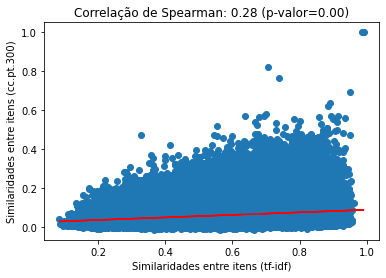

In [359]:
#& (df_similaridades.item1_area == 'LC') & (df_similaridades.item2_area == 'LC') & (df_similaridades.sim_q_we_own < 0.99)
df = df_similaridades[(df_similaridades.e_maior == False)]
#realizar a correlação de spearman entre as similaridades
# calcular a correlação de Spearman
corr, p_value = spearmanr(df.sim_q_tf_idf.values, df.sim_q_we.values)
regressao = np.polyfit(df.sim_q_tf_idf.values, df.sim_q_we.values, 1)

#se p menor que 0.05 o erro é menor se a hipótese nula for rejeitada
if p_value < 0.05:
    print("A hipótese nula foi rejeitada. Há correlação entre as variáveis", 'p-value:', p_value, 'correlação:', corr)
else:
    print("A hipótese nula não foi rejeitada. Não há correlação entre as variáveis.", 'p-value:', p_value, 'correlação:', corr)

# plotar a correlação de Spearman
plt.scatter(df.sim_q_tf_idf.values, df.sim_q_we.values)
plt.plot(df.sim_q_tf_idf.values, regressao[0]*df.sim_q_tf_idf.values + regressao[1], color='red')
plt.title(f'Correlação de Spearman: {corr:.2f} (p-valor={p_value:.2f})')
plt.xlabel('Similaridades entre itens (tf-idf)')
plt.ylabel('Similaridades entre itens (cc.pt.300)')
plt.show()

**Se a correlação de Spearman entre duas variáveis for de 0.28 e o p-valor for igual a 0, significa que há uma relação fraca entre as variáveis e que esta relação é estatisticamente significativa. Valores próximos de 0 para a correlação indicam uma relação fraca ou não linear entre as variáveis. O p-valor é a probabilidade de observarmos uma correlação tão ou mais extrema que a medida de correlação de Spearman observada, se não houvesse relação real entre as variáveis. Um p-valor igual a 0 significa que é extremamente improvável que a correlação observada tenha sido obtida por acaso, e, portanto, é considerado estatisticamente significativo.**

#### treinamento com o conjunto e tf-idf

A hipótese nula foi rejeitada. Há correlação entre as variáveis p-value: 0.0 correlação: 0.5299406745614161


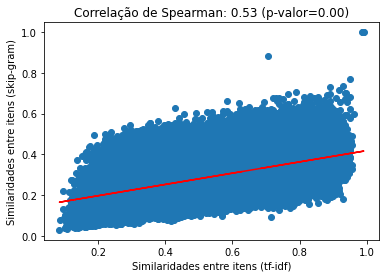

In [398]:
#& (df_similaridades.item1_area == 'LC') & (df_similaridades.item2_area == 'LC') & (df_similaridades.sim_q_we_own_own < 0.99)
df = df_similaridades[(df_similaridades.e_maior == False)]
#realizar a correlação de spearman entre as similaridades
# calcular a correlação de Spearman
corr, p_value = spearmanr(df.sim_q_tf_idf.values, df.sim_q_we_own.values)
regressao = np.polyfit(df.sim_q_tf_idf.values, df.sim_q_we_own.values, 1)

#se p menor que 0.05 o erro é menor se a hipótese nula for rejeitada
if p_value < 0.05:
    print("A hipótese nula foi rejeitada. Há correlação entre as variáveis", 'p-value:', p_value, 'correlação:', corr)
else:
    print("A hipótese nula não foi rejeitada. Não há correlação entre as variáveis.", 'p-value:', p_value, 'correlação:', corr)

# plotar a correlação de Spearman
plt.scatter(df.sim_q_tf_idf.values, df.sim_q_we_own.values)
plt.plot(df.sim_q_tf_idf.values, regressao[0]*df.sim_q_tf_idf.values + regressao[1], color='red')
plt.title(f'Correlação de Spearman: {corr:.2f} (p-valor={p_value:.2f})')
plt.xlabel('Similaridades entre itens (tf-idf)')
plt.ylabel('Similaridades entre itens (skip-gram)')
plt.show()

**Se a correlação de Spearman entre duas variáveis for de 0.53 e o p-valor for igual a 0, significa que há uma relação moderada entre as variáveis e que esta relação é estatisticamente significativa. Valores próximos de 0 para a correlação indicam uma relação fraca ou não linear entre as variáveis. O p-valor é a probabilidade de observarmos uma correlação tão ou mais extrema que a medida de correlação de Spearman observada, se não houvesse relação real entre as variáveis. Um p-valor igual a 0 significa que é extremamente improvável que a correlação observada tenha sido obtida por acaso, e, portanto, é considerado estatisticamente significativo.**

### correlação entre similaridade e diferença entre os parâmetros

#### parâmetro a

A hipótese nula foi rejeitada. Há correlação entre as variáveis p-value: 2.1284160170151086e-69 correlação: 0.012959058136617225


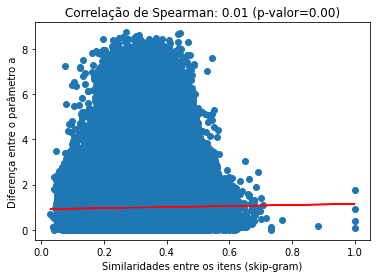

In [410]:
#& (df_similaridades.item1_area == 'LC') & (df_similaridades.item2_area == 'LC') & (df_similaridades.sim_q_we_own < 0.99)
df = df_similaridades[(df_similaridades.e_maior == False)]
#realizar a correlação de spearman entre as similaridades
# calcular a correlação de Spearman
corr, p_value = spearmanr(df.sim_q_we_own.values, df.dif_param_a.values)
regressao = np.polyfit(df.sim_q_we_own.values, df.dif_param_a.values, 1)

#se p menor que 0.05 o erro é menor se a hipótese nula for rejeitada
if p_value < 0.05:
    print("A hipótese nula foi rejeitada. Há correlação entre as variáveis", 'p-value:', p_value, 'correlação:', corr)
else:
    print("A hipótese nula não foi rejeitada. Não há correlação entre as variáveis.", 'p-value:', p_value, 'correlação:', corr)

# plotar a correlação de Spearman
plt.scatter(df.sim_q_we_own.values, df.dif_param_a.values)
plt.plot(df.sim_q_we_own.values, regressao[0]*df.sim_q_we_own.values + regressao[1], color='red')
plt.title(f'Correlação de Spearman: {corr:.2f} (p-valor={p_value:.2f})')
plt.xlabel('Similaridades entre os itens (skip-gram)')
plt.ylabel('Diferença entre o parâmetro a')
plt.show()

#### parâmetro b

A hipótese nula foi rejeitada. Há correlação entre as variáveis p-value: 0.0 correlação: -0.04345048812047198


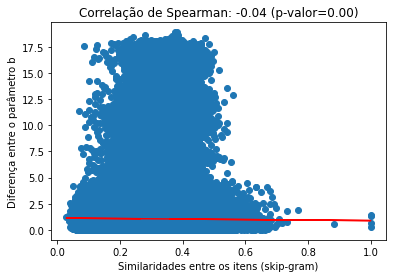

In [409]:
#& (df_similaridades.item1_area == 'LC') & (df_similaridades.item2_area == 'LC') & (df_similaridades.sim_q_we_own < 0.99)
df = df_similaridades[(df_similaridades.e_maior == False)]
#realizar a correlação de spearman entre as similaridades
# calcular a correlação de Spearman
corr, p_value = spearmanr(df.sim_q_we_own.values, df.dif_param_b.values)
regressao = np.polyfit(df.sim_q_we_own.values, df.dif_param_b.values, 1)

#se p menor que 0.05 o erro é menor se a hipótese nula for rejeitada
if p_value < 0.05:
    print("A hipótese nula foi rejeitada. Há correlação entre as variáveis", 'p-value:', p_value, 'correlação:', corr)
else:
    print("A hipótese nula não foi rejeitada. Não há correlação entre as variáveis.", 'p-value:', p_value, 'correlação:', corr)

# plotar a correlação de Spearman
plt.scatter(df.sim_q_we_own.values, df.dif_param_b.values)
plt.plot(df.sim_q_we_own.values, regressao[0]*df.sim_q_we_own.values + regressao[1], color='red')
plt.title(f'Correlação de Spearman: {corr:.2f} (p-valor={p_value:.2f})')
plt.xlabel('Similaridades entre os itens (skip-gram)')
plt.ylabel('Diferença entre o parâmetro b')
plt.show()

#### parâmetro c

A hipótese nula foi rejeitada. Há correlação entre as variáveis p-value: 6.793138194852422e-12 correlação: 0.005050322286517786


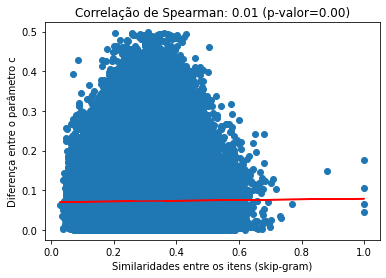

In [411]:
#& (df_similaridades.item1_area == 'LC') & (df_similaridades.item2_area == 'LC') & (df_similaridades.sim_q_we_own < 0.99)
df = df_similaridades[(df_similaridades.e_maior == False)]
#realizar a correlação de spearman entre as similaridades
# calcular a correlação de Spearman
corr, p_value = spearmanr(df.sim_q_we_own.values, df.dif_para_c.values)
regressao = np.polyfit(df.sim_q_we_own.values, df.dif_para_c.values, 1)

#se p menor que 0.05 o erro é menor se a hipótese nula for rejeitada
if p_value < 0.05:
    print("A hipótese nula foi rejeitada. Há correlação entre as variáveis", 'p-value:', p_value, 'correlação:', corr)
else:
    print("A hipótese nula não foi rejeitada. Não há correlação entre as variáveis.", 'p-value:', p_value, 'correlação:', corr)

# plotar a correlação de Spearman
plt.scatter(df.sim_q_we_own.values, df.dif_para_c.values)
plt.plot(df.sim_q_we_own.values, regressao[0]*df.sim_q_we_own.values + regressao[1], color='red')
plt.title(f'Correlação de Spearman: {corr:.2f} (p-valor={p_value:.2f})')
plt.xlabel('Similaridades entre os itens (skip-gram)')
plt.ylabel('Diferença entre o parâmetro c')
plt.show()

## nuvem de palavras

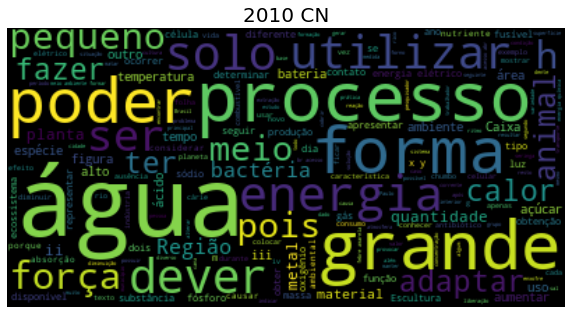

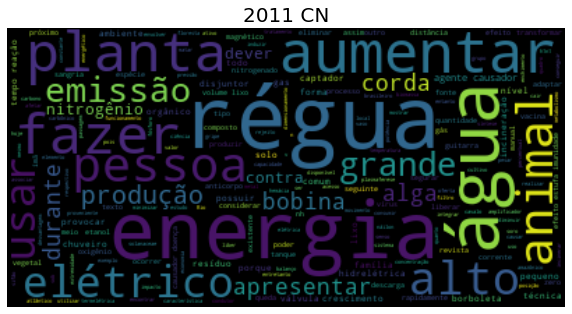

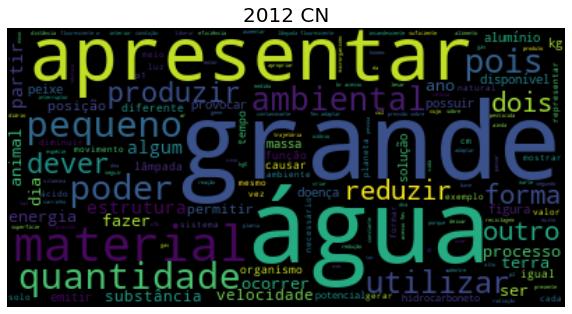

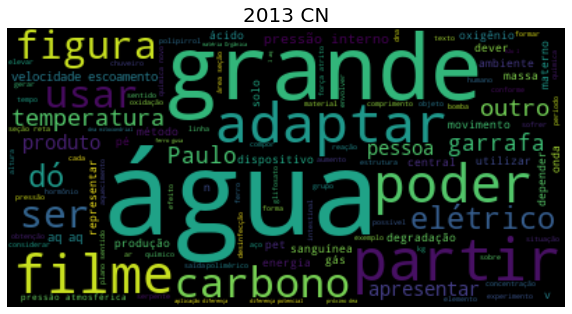

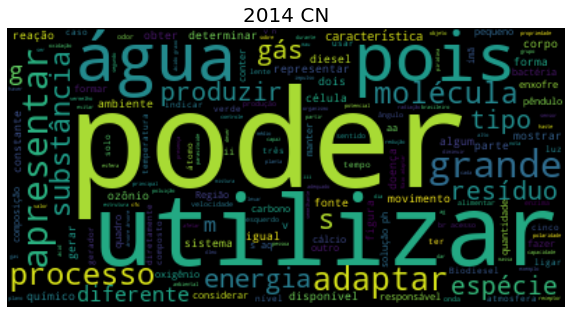

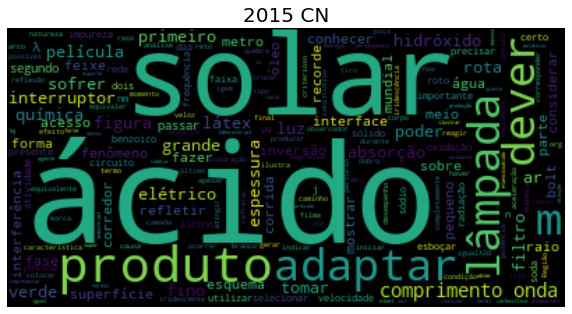

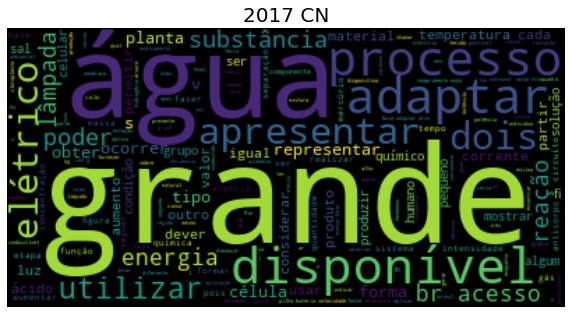

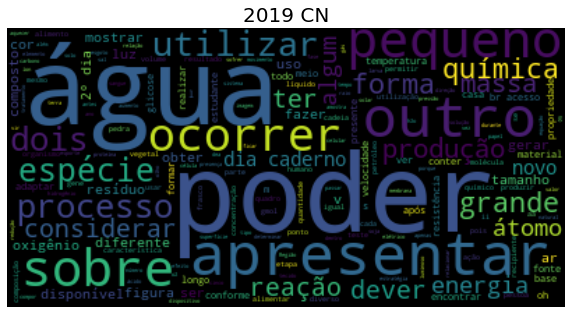

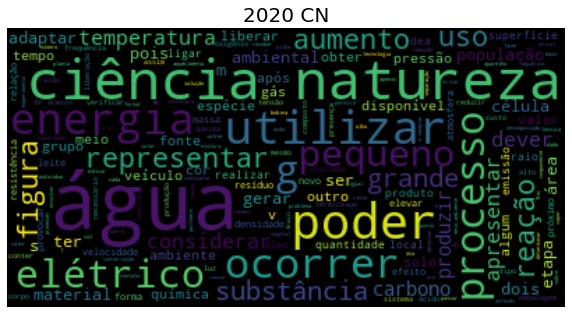

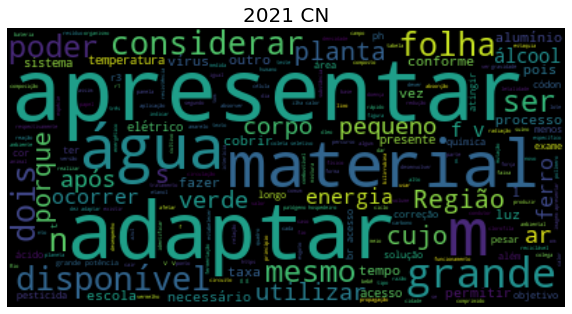

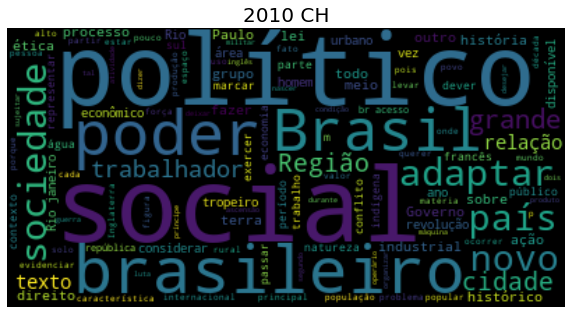

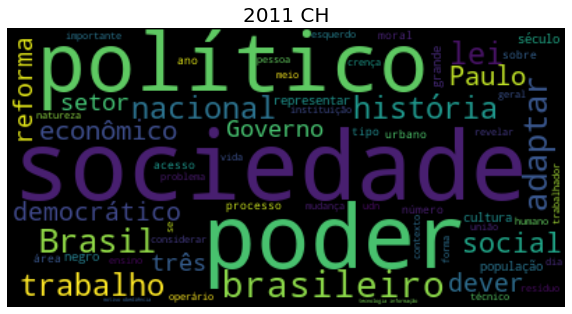

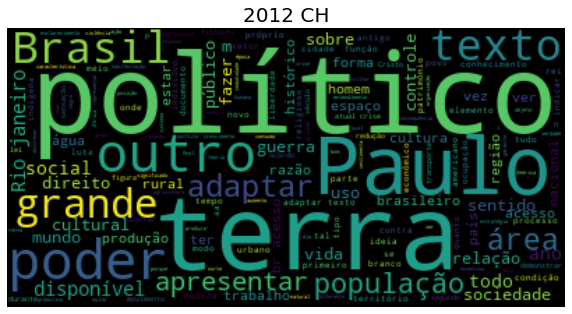

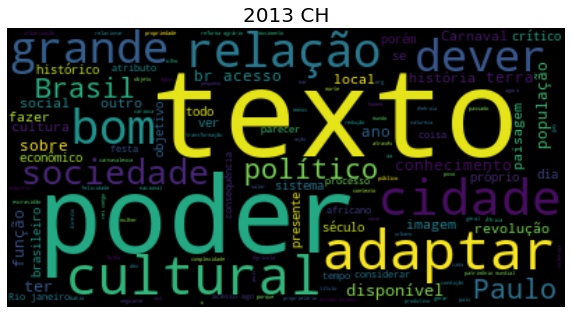

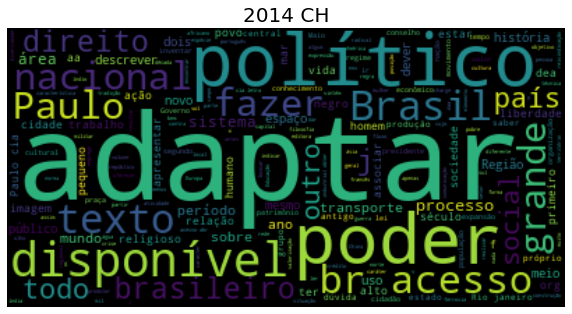

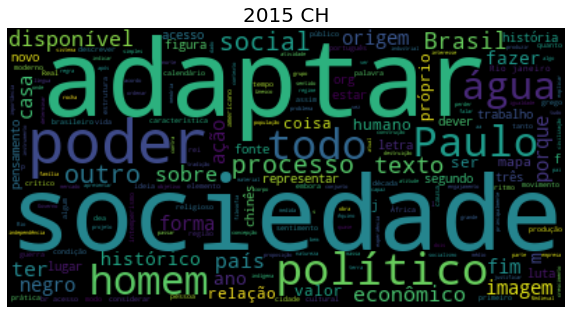

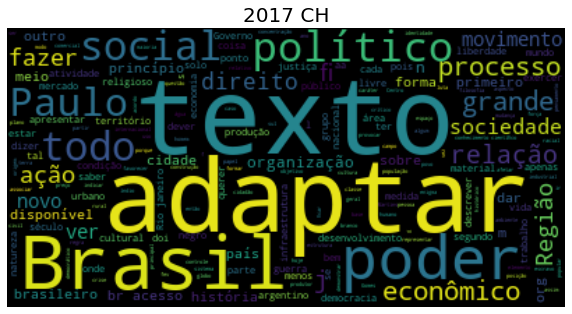

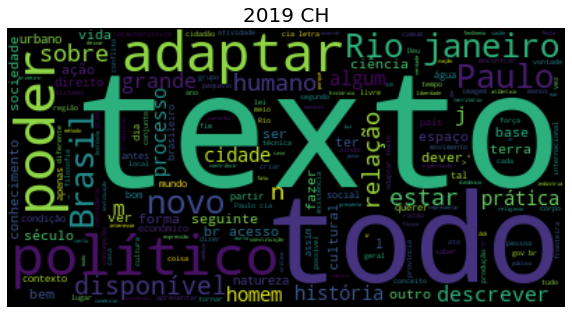

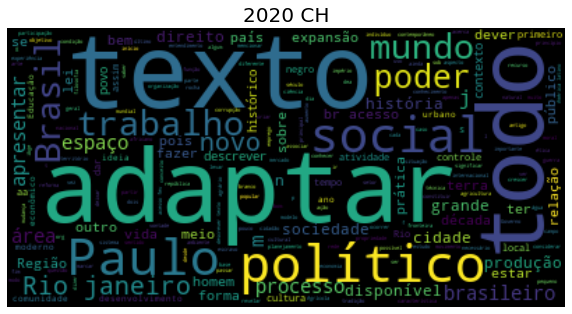

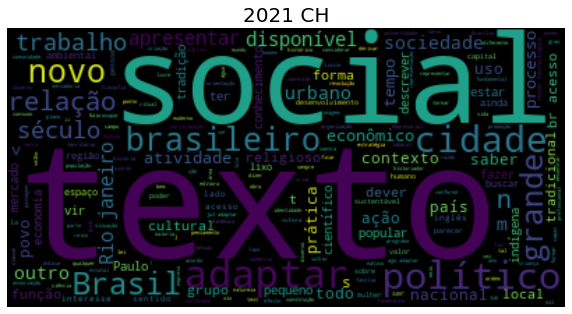

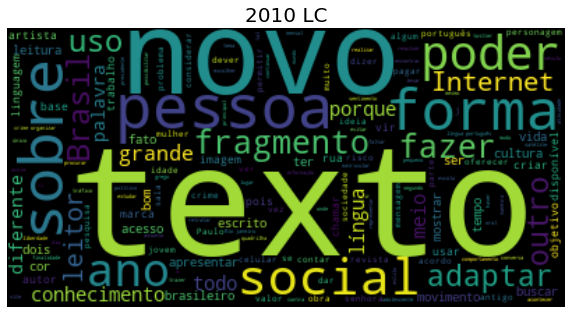

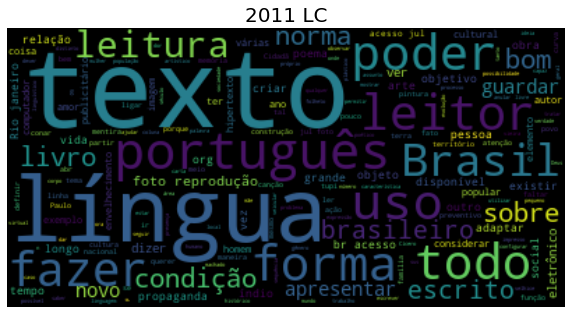

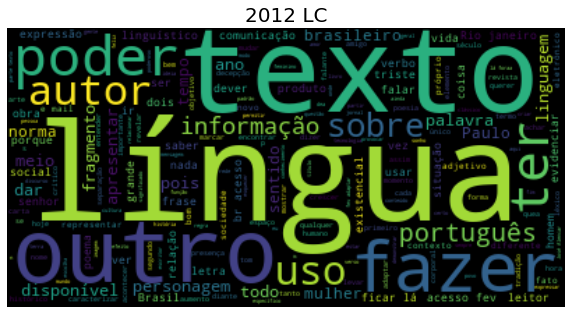

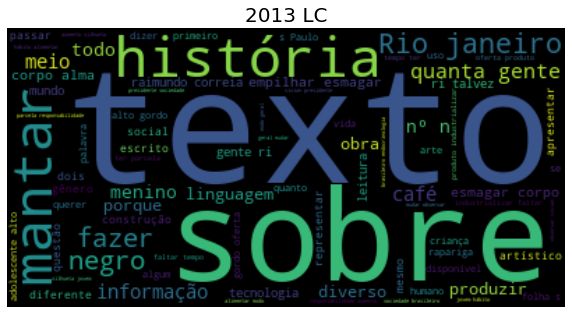

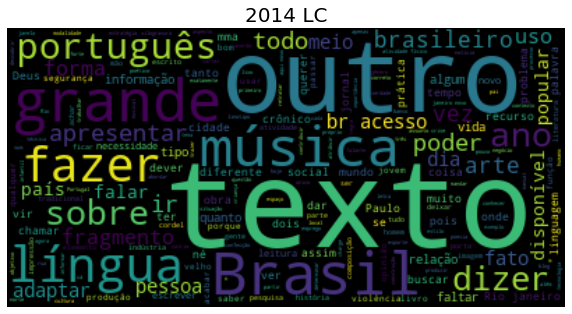

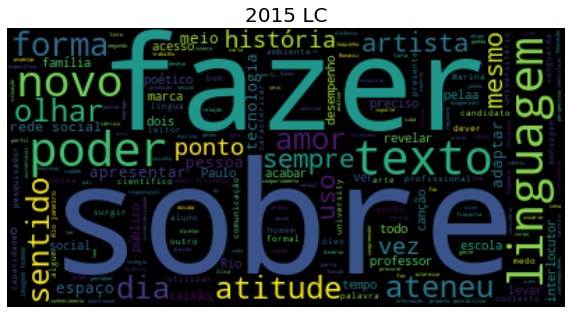

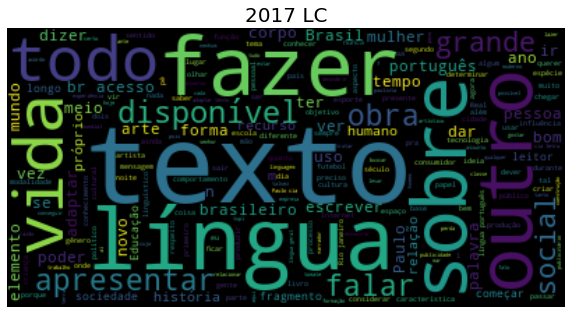

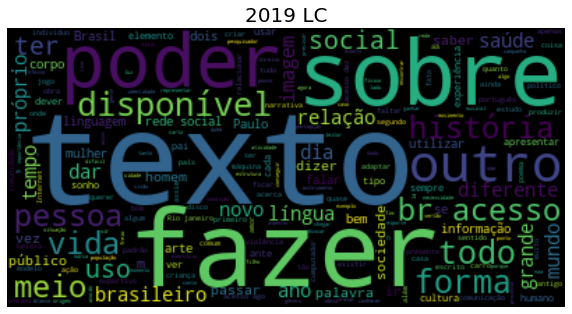

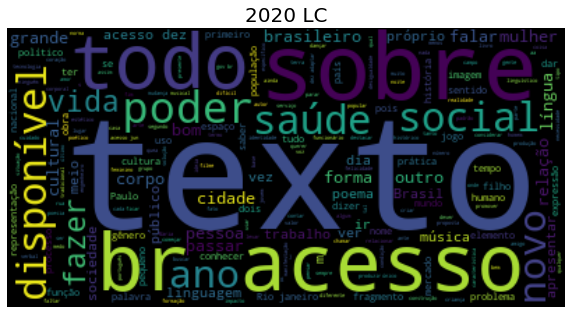

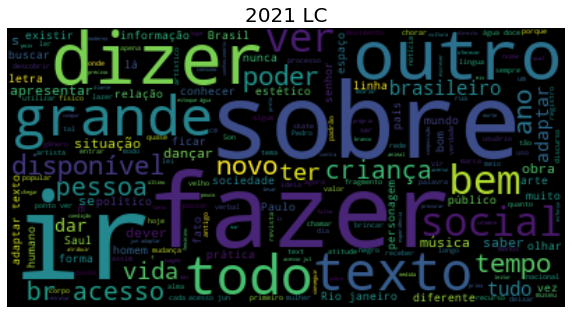

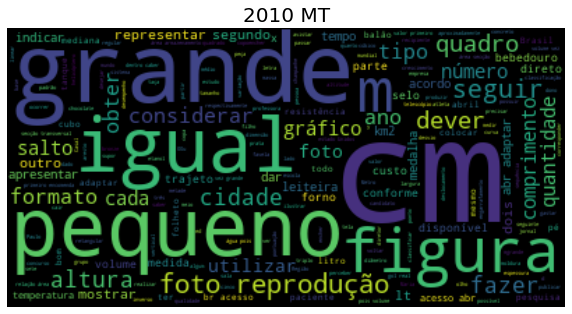

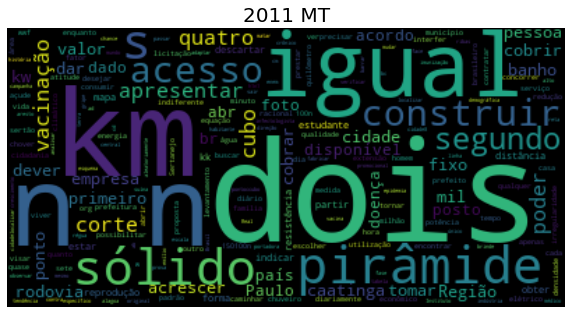

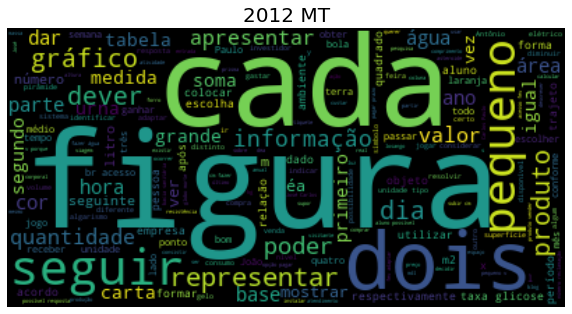

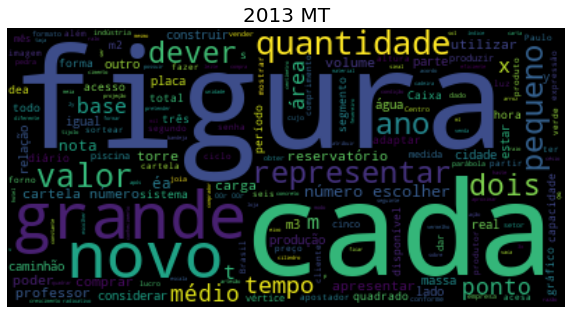

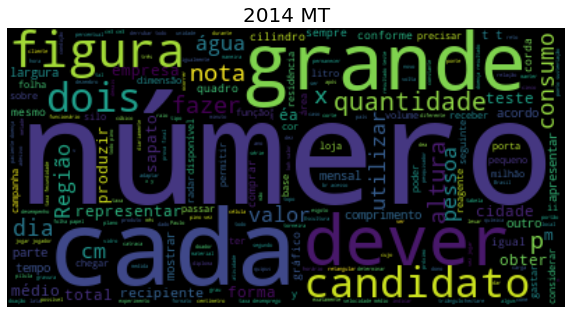

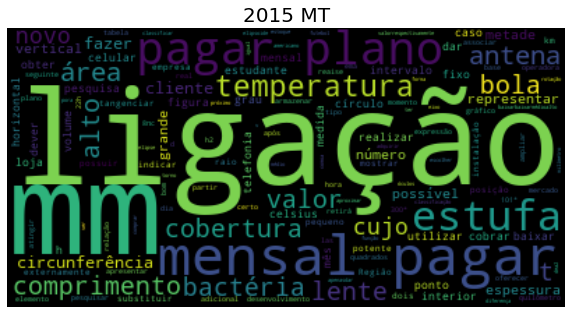

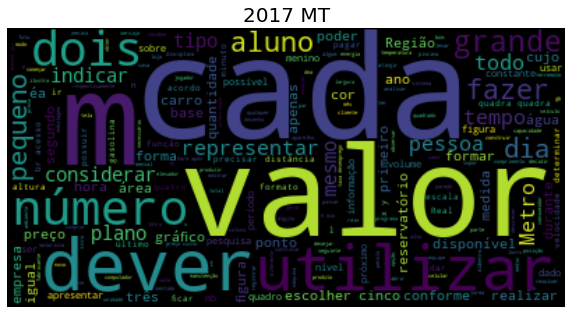

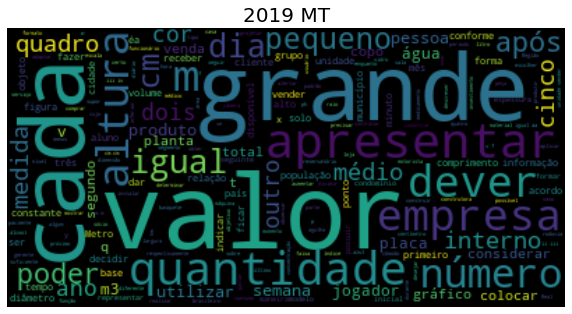

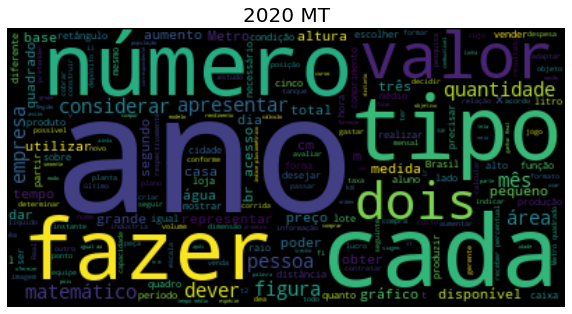

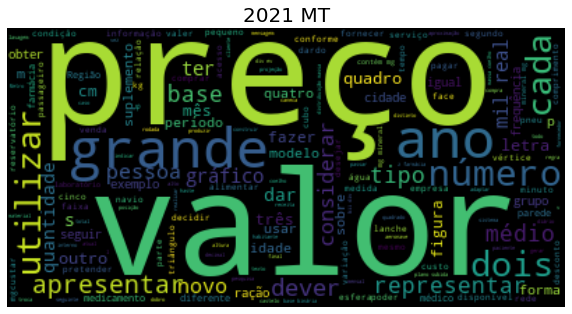

In [392]:
#função que gera a imagem de uma nuvem de palavras
def gera_nuvem(dataset, ano, area):
    # Separar os textos de acordo com a sua classificação
    # Lista com os textos
    textos_classe = dataset[(dataset.sg_area == area) & (dataset.ano == ano)]['texto_questao_tratado'].str.replace(' b ', '').str.replace(' c ', '').str.replace(' d ', '').values 

    # Criar nuvem de palavras para a classe 1
    wc_classe = WordCloud().generate(' '.join(textos_classe))
    # Criar figura e eixo
    fig, ax = plt.subplots(figsize=(10, 10))
    # Mostrar imagem no eixo
    ax.imshow(wc_classe, interpolation='bilinear')
    # Adicionar título
    ax.set_title(str(ano) + ' ' + area, fontsize=20)
    ax.axis("off")
    plt.show()
    
for ano in dataset.ano.unique():
    gera_nuvem(dataset, int(ano), 'CN')
    
for ano in dataset.ano.unique():
    gera_nuvem(dataset, int(ano), 'CH')
    
for ano in dataset.ano.unique():
    gera_nuvem(dataset, int(ano), 'LC')
    
for ano in dataset.ano.unique():
    gera_nuvem(dataset, int(ano), 'MT')